In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
final = pd.read_csv('../input/data/train/final.csv')
final = final.loc[:, ['path', 'label','age','id']]

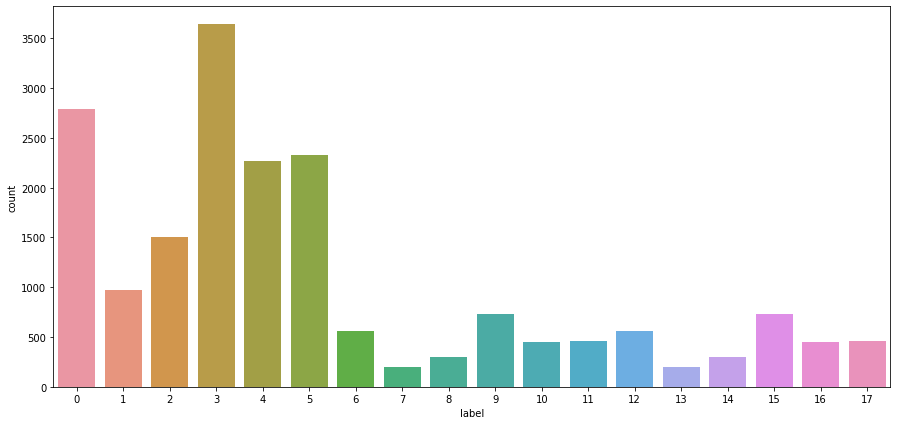

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x='label', data=final, ax=ax)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, train_csv, transform):
        self.X = train_csv['path']
        self.y = train_csv['label']
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform: image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.X)

In [5]:
transform = transforms.Compose([
    ToTensor(),
])

In [7]:
from sklearn.model_selection import train_test_split
dt = pd.read_csv('../input/data/train/distinct.csv')
train_set, val_set = train_test_split(dt, test_size=0.2,
                                      shuffle=True, stratify=dt['age'],
                                      random_state = 42)

In [8]:
train_set = final[final['id'].isin(train_set['id'])]
val_set = final[final['id'].isin(val_set['id'])]

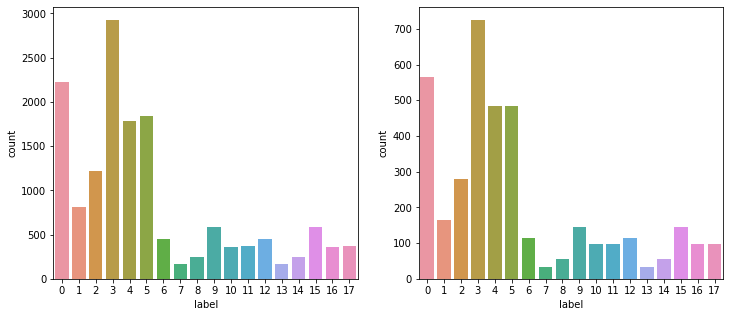

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x='label', data=train_set, ax=axes[0])
sns.countplot(x='label', data=val_set, ax=axes[1])

In [11]:
BATCH_SIZE = 64
train_dataset = CustomDataset(train_set, transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
valid_dataset = CustomDataset(val_set, transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [14]:
import math

for param in resnet18.parameters():
    param.requires_grad = False

CLASS_NUM = 18
resnet18.fc = torch.nn.Linear(in_features=resnet18.fc.in_features, out_features=CLASS_NUM)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [18]:
resnet18.to(device)

LEARNING_RATE = 0.001
NUM_EPOCH = 10

loss_fn = FocalLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LEARNING_RATE)
dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

In [22]:
best_test_accuracy = 0
best_test_loss = 9999.
train_losses, val_losses,  train_accs, val_accs= [], [], [], []

for epoch in range(NUM_EPOCH):    
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train": resnet18.train()
        elif phase == "test": resnet18.eval()
        
        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"):
                logits = resnet18(images)
                _, preds = torch.max(logits, 1)
                loss = loss_fn(logits, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
             
        if phase == "train":
            train_losses.append(epoch_loss) 
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)
        
        print(f"epoch {epoch} >> {phase} : 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc: best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss: best_test_loss = epoch_loss
    
print("Training Done.")
print(f"Best Accuracy : {best_test_accuracy}, Best Loss : {best_test_loss}")
        

epoch 0 >> train : 평균 Loss : 0.276, 평균 Accuracy : 0.806
epoch 0 >> test : 평균 Loss : 0.341, 평균 Accuracy : 0.745
epoch 1 >> train : 평균 Loss : 0.273, 평균 Accuracy : 0.811
epoch 1 >> test : 평균 Loss : 0.342, 평균 Accuracy : 0.753
epoch 2 >> train : 평균 Loss : 0.272, 평균 Accuracy : 0.811
epoch 2 >> test : 평균 Loss : 0.340, 평균 Accuracy : 0.750
epoch 3 >> train : 평균 Loss : 0.271, 평균 Accuracy : 0.812
epoch 3 >> test : 평균 Loss : 0.341, 평균 Accuracy : 0.751
epoch 4 >> train : 평균 Loss : 0.270, 평균 Accuracy : 0.811
epoch 4 >> test : 평균 Loss : 0.341, 평균 Accuracy : 0.753
epoch 5 >> train : 평균 Loss : 0.264, 평균 Accuracy : 0.817
epoch 5 >> test : 평균 Loss : 0.340, 평균 Accuracy : 0.750
epoch 6 >> train : 평균 Loss : 0.266, 평균 Accuracy : 0.815
epoch 6 >> test : 평균 Loss : 0.337, 평균 Accuracy : 0.751
epoch 7 >> train : 평균 Loss : 0.265, 평균 Accuracy : 0.816
epoch 7 >> test : 평균 Loss : 0.337, 평균 Accuracy : 0.753
epoch 8 >> train : 평균 Loss : 0.262, 평균 Accuracy : 0.814
epoch 8 >> test : 평균 Loss : 0.332, 평균 Accuracy : 0.752
e

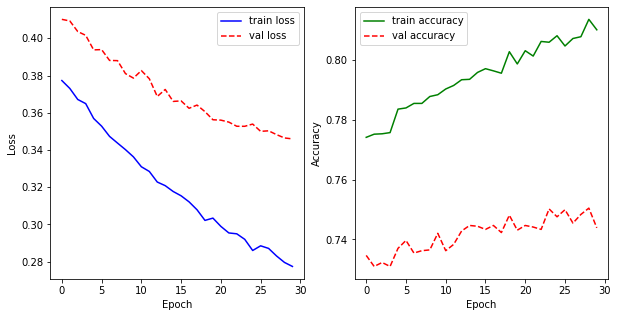

In [21]:
plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
# loss = [i.detach().numpy() for i in losses]
plt.plot(train_losses, 'b-', label='train loss') 
plt.plot(val_losses, 'r--', label='val loss') 
plt.legend()

plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(train_accs, 'g-', label='train accuracy') 
plt.plot(val_accs, 'r--', label='val accuracy') 
plt.legend()
plt.show()

In [23]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [24]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [25]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    ToTensor(),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
model = resnet18
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
        
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


In [26]:
sub = pd.read_csv('/opt/ml/input/data/eval/submission.csv')
sub.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,14
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,17
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,13
